## Player
**Player 클래스의 필드**

- currant_sum (int):  현재까지 얻은 카드 숫자 합
- card_of_dealer (int): 딜러가 오픈한 하나의 카드 숫자
- usable_ace (bool): 사용가능한 ace가 있는가
- using_ace (bool): ace를 쓰는가
<br>

**상태 정의**

(총합, 에이스 사용, 딜러 카드)
<br>

**알고 싶은 것**

나의 패와 공개된 딜러의 패를 알고 있을 때 hit(1장 더) or stay(그만)
<br>

**전제**
- 패에서 각 카드가 등장할 확률은 독립시행이다. -> 랜덤 함수로 뽑을 수 있다. (다만, 카드 덱 단위로 만들었다 가정하여 실제 덱과 비율은 일치)
- 더블과 스플릿은 존재하지 않는다고 가정 -> hit or stay
    - 때문에 \~10은 무조건 stay하는 것이 당연하므로 11\~21에 해당하는 숫자만으로 학습시킨다.
    - 스플릿이 없기 때문에 카드의 합 & 에이스 유무만 중요하게 된다.
- 에피소드의 길이가 짧기 때문에 할인율이 1로 설정된 것

**의문**
- 에이스가 여러 장이면 어떡하지? 처음 얻은 에이스를 제외하고는 무조건 에이스를 11로 쓰는 것은 손해이다. (이미 10 초과이므로)
- 왜 11부터 21까지의 수를 랜덤으로 선택할까? 10 이하면 무조건 hit이 맞기 때문에 따로 전략을 도출할 필요가 없기 때문
    - 그렇다면

In [276]:
from enum import Enum
import matplotlib.pyplot as plt
import random as r
from typing import NewType
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

State = NewType('State', tuple[int, bool, int])
Card = NewType('Card', int)
Pair = NewType('Pair', tuple[State, bool])

class Player:
    currant_sum: int
    card_of_dealer: int
    is_ace_available: bool
    is_ace_used_as_11: bool

    # 플레이어 초기화
    def __init__(self, currant_sum: int, is_ace_available: bool, card_of_dealer: int):
        self.currant_sum = currant_sum
        self.card_of_dealer = card_of_dealer

        self.is_ace_available = is_ace_available

        if currant_sum == 11:
            # 11일 때 Ace가 11인 상태로 껴있다면, 2장일 수 없기 때문
            self.is_ace_used_as_11 = False
        else:
            # 자동적으로 에이스를 사용하자.
            self.is_ace_used_as_11 = self.is_ace_available

    # 새로운 카드를 덱에 추가
    def receive_card(self, new_card: Card) -> None:

        # 21을 넘는데 ace를 쓰고 있다면 자동적으로 없애기
        if self.is_ace_used_as_11 and self.currant_sum + new_card > 21:
            self.is_ace_used_as_11 = False
            self.currant_sum += new_card - 10
        else:
            self.currant_sum += new_card

    # 상태 정의:
    def get_state(self) -> State:
        return State((self.currant_sum, self.is_ace_available, self.card_of_dealer))

    # 총합 받기
    def get_currant_sum(self) -> int:
        return self.currant_sum

    # hit해야 하는가?
    def next_action(self, policy: dict[State, bool]) -> bool:
        return policy[self.get_state()]

    # 21 초과면 패배
    def is_bust(self) -> bool:
        return self.get_currant_sum() > 21

In [277]:
class Dealer:
    cards: list[Card]

    # 새로운 덱
    def __init__(self, cards: list[Card]):
        self.cards = cards

    # 딜러가 카드를 추가로 받는다.
    def receive_card(self, card: Card) -> None:
        self.cards.append(card)

    # 딜러가 가진 현재 카드의 숫자 합 반환
    def get_currant_sum(self) -> int:
        currant_sum = 0
        ace_count = 0

        # 합 구하기
        for card in self.cards:
            if card == 1:
                ace_count += 1
            else:
                currant_sum += card

        # 에이스는 특수 처리
        while ace_count > 0:
            ace_count -= 1
            currant_sum += 11

            if currant_sum > 21:
                ace_count += 1
                currant_sum -= 11
                currant_sum += ace_count
                break

        return currant_sum

    # 딜러는 17 미만이면 무조건적으로 카드를 더 받아야 함.
    def should_hit(self) -> bool:
        return self.get_currant_sum() < 17

    # 딜러 역시 21 초과면 bust
    def is_bust(self) -> bool:
        return self.get_currant_sum() > 21

In [278]:
# 에피소드를 겪으며 발생하는 pair=(상태, 행동)를 기록해두는 용도
class EpisodeExperienceInfo:
    # 유무 확인용
    # 이때 중요한 것은 한 번 겪은 상태를 한 에피소드 내에서 겪을 일이 없다는 점 -> set으로 써도 상관 없다!
    state_action_set: set[Pair]

    def __init__(self):
        self.state_action_set = set()

    def add_pair(self, pair: Pair) -> None:
        self.state_action_set.add(pair)

In [279]:
class MonteCarloController:
    q_map: dict[Pair, float]
    policy: dict[State, bool]
    returns: dict[Pair, int]

    def __init__(self):
        self.q_map = {}
        self.policy = {}
        self.returns = {}

        for player_sum in range(11, 22):
            for does_ace_exist in range(2):
                for dealers_card in range(1, 11):
                    player_state = (player_sum, bool(does_ace_exist), dealers_card)
                    self.q_map[Pair((player_state, False))] = 0
                    self.q_map[Pair((player_state, True))] = 0
                    self.returns[Pair((player_state, False))] = 0
                    self.returns[Pair((player_state, True))] = 0

                    if player_sum == 20 or player_sum == 21:
                        self.policy[player_state] = False
                    else:
                        self.policy[player_state] = True


    def evaluate_and_improve_policy(self, episodeExperienceInfo: EpisodeExperienceInfo, reward: int):
        for pair in episodeExperienceInfo.state_action_set:
            # returns[pair]: pair=(상태, 행동 결정)을 경험한 횟수
            self.returns[pair] += 1

            # q 값 업데이트
            self.q_map[pair] = self.q_map[pair] * (1 - 1/self.returns[pair]) + (reward - self.q_map[pair]) / self.returns[pair]

            # 상태는 pair의 첫번째 원소
            state:State = pair[0]

            # 정책 업데이트: Hit과 Stay 중 q 값이 더 큰 것인 지에 따라 hit 여부 결정
            should_hit = self.q_map[Pair((state, True))] > self.q_map[Pair((state, False))]

            # 정책 업데이트
            self.policy[state] = should_hit

    def play_episode(self):

        # 초기 상태 랜덤 지정
        player_sum = r.randint(11, 21)
        dealer_open_card = new_card()
        is_ace_available = bool(r.randint(0, 1))

        # 플레이어와 딜러 생성
        player = Player(player_sum, is_ace_available, dealer_open_card)
        dealer = Dealer([dealer_open_card])

        # 기록 보관소 생성
        episode_experience_info = EpisodeExperienceInfo()

        # 몬테카를로의 특징: 학습 결과를 이용하지 않고 무작위적으로 학습을 진행
        hit_action = bool(r.randint(0, 1))

        # 현재의 결정을 기록해두자.
        episode_experience_info.add_pair((player.get_state(), hit_action))

        # player가 hit하기로 결정했다면?
        if hit_action:
            player.receive_card(new_card())

            while not player.is_bust() and player.next_action(self.policy):
                episode_experience_info.add_pair((player.get_state(), True))
                player.receive_card(new_card())

        # 플레이어가 bust되면? 딜러 결과 상관없이 죽음
        if player.is_bust():
            self.evaluate_and_improve_policy(episode_experience_info, -1)
            return

        episode_experience_info.add_pair((player.get_state(), False))
        dealer.receive_card(new_card())

        while not dealer.is_bust() and dealer.should_hit():
            dealer.cards.append(new_card())

        if dealer.is_bust() or dealer.get_currant_sum() < player.get_currant_sum():
            self.evaluate_and_improve_policy(episode_experience_info, 1)
        elif dealer.get_currant_sum() > player.get_currant_sum():
            self.evaluate_and_improve_policy(episode_experience_info, -1)
        else:
            self.evaluate_and_improve_policy(episode_experience_info, 0)

    def visualize_scatter(self):
        dealer_of_non_ace = []
        player_of_non_ace = []
        action_of_non_ace = []

        dealer_of_ace = []
        player_of_ace = []
        action_of_ace = []

        for player_state in self.policy:
            # 에이스가 있었다면
           if player_state[1]:
               dealer_of_ace.append(player_state[2])
               player_of_ace.append(player_state[0])
               if self.policy[player_state]:
                   action_of_ace.append('Hit')
               else:
                   action_of_ace.append('Stay')

           else:
               dealer_of_non_ace.append(player_state[2])
               player_of_non_ace.append(player_state[0])
               if self.policy[player_state]:
                   action_of_non_ace.append('Hit')
               else:
                   action_of_non_ace.append('Stay')

        df_ace = pd.DataFrame({"dealer": dealer_of_ace, "player":player_of_ace, "action":action_of_ace})
        df_non_ace = pd.DataFrame({"dealer": dealer_of_non_ace, "player":player_of_non_ace, "action":action_of_non_ace})

        plt.figure(0)
        plt.title('With Usable Ace')
        scatter = sns.scatterplot(x="dealer", y="player", hue="action", data=df_ace)
        plt.xticks(range(1,11), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
        plt.yticks(range(11,22), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

        plt.figure(1)
        plt.title('Without Usable Ace')
        scatter = sns.scatterplot(x="dealer", y="player", hue="action", data=df_non_ace)
        plt.xticks(range(1,11), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
        plt.yticks(range(11,22), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

        plt.show()

    def visualize_heatmap(self):
        my_colors = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
        cmap = LinearSegmentedColormap.from_list('Custom', my_colors, len(my_colors))

        list = [[0 for i in range(11)] for j in range(12)]
        for i in range(11, 22):
            for j in range(1, 11):
                for k in range(0, 2):
                    _k = bool(k)

        sns.heatmap()

# 새로운 카드를 랜덤하게 반환
def new_card() -> Card:
    card = r.randint(1, 13)

    if card > 9:
        return Card(10)
    else:
        return Card(card)

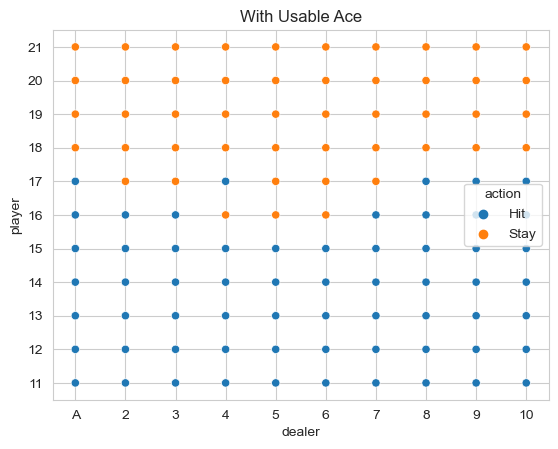

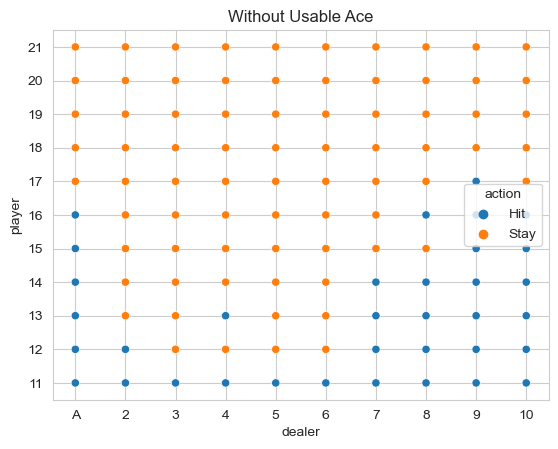

In [280]:
if __name__ == "__main__":
    monteCarloController = MonteCarloController()

    for i in range(100000):
        monteCarloController.play_episode()

    monteCarloController.visualize_scatter()